# Monte Carlo Confidence Intervals for Numerical Integration
- Adapted from the [code](https://github.com/aaditj1962161/Betting-Paper-Simulations-for-QMC/blob/paper-simulations/simulations/Fixed-time/Betting%20IID%20vs%20QMC.ipynb) of Jain et al. "Empirical Bernstein and betting confidence intervals for randomized quasi-Monte Carlo"

Importing the necessary modules:

In [1]:
# Automatically reload modules when they change
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.stats import norm,t
from scipy.stats import beta
from confseq.betting import betting_ci_seq
from confseq.predmix import predmix_empbern_ci_seq
import qmcpy as qp
import pandas as pd
import os
import time
from ebe import ebe_ci_seq

The parameters used for our numerical experiments

In [2]:
alpha = 0.05 # Significance level, confidence level = 1 - alpha

# parameters used for the integrand problem

# The integrand functions:
fs = {
    "smooth_1d": lambda x: x[...,0]*np.exp(x[...,0])/np.exp(1), 
    "discontinuous_1d": lambda x: (x[...,0]) < (1/3),
    "discontinuous_2d": lambda x: (x[...,0]+x[...,1])>=(2/3),
}
# parameters used for the ridge functions

# The ridge functions:
gs = {
    "jmp": lambda w: w>=1, 
    "knk": lambda w: ((np.minimum(np.maximum(-2,w),1)) + 2) / 3,
    "smo": lambda w: norm.cdf(w + 1),
    "fin": lambda w: np.minimum(1,((np.sqrt(np.maximum(w+2,0)))/2)),
}
# Ridge function dimensions to test
d = np.array([1]) 
ci_methods = np.array(["CLT", "EB", "Betting", "EBE"]) # The different CI methods

# parameters used for the integrand problems and ridge functions

# Vector of sample sizes
N_vary = np.array([2**12, 2**14, 2**16, 2**18])
# The vector of number points generated per replication
# Choose n = 1 for Monte Carlo sampling
n_vary = 2 ** np.arange(0, 1) 
M = 20 # The number of times the experiment is repeated

# seed settings

global_seed = 7
parent_seed = np.random.SeedSequence(global_seed)

# Create a cache directory for intermediate results
cache_dir = "mc_results"
os.makedirs(cache_dir, exist_ok=True)

The function to generate IID replications of QMC samples (reduces to Monte Carlo sampling when n = 1)

In [3]:
def gen_qmc_samples_iid(discrete_distrib, true_measure, n = 2**8, function = None, ridge = False):
    assert isinstance(discrete_distrib,(qp.DigitalNetB2,qp.Lattice,qp.IIDStdUniform))
    assert true_measure in ["uniform","beta"]
    x_rld = discrete_distrib.gen_samples(n).reshape((discrete_distrib.replications,n,discrete_distrib.d))
    if true_measure=="beta":
        x_rld = beta(a=beta_param[0], b=beta_param[1]).ppf(x_rld)
    if ridge is True:
        return x_rld
    if function is None:
        y_rld = x_rld[...,0]
    else:
        y_rld = function(x_rld)
    return y_rld.mean(1),y_rld.flatten()

The function to return the sequence of CLT CI Widths

In [4]:
def clt_ci_seq (values, times, alpha = 0.05):
    assert np.all(times <= len(values)), f"Invalid values in times: {times[times > len(values)]}"
    ci_arr = np.zeros(len(times))
    for time in range (len(times)):
        curr_val = values[0:times[time]]
        ci_arr[time] = 2 * (t.ppf(1 - alpha / 2,times[time] - 1) * curr_val.std(ddof=1) / np.sqrt(times[time])) 
    return ci_arr

Generating the uniform sample points that will be used to numerically integrate the ridge and three test functions

In [5]:
x_qmc_arr = np.empty(len(n_vary), dtype=object)
max_d = max(d.max(), 2) # d = 2 is needed for the discontinuous_2d function
for i in range(len(n_vary)):
    print(f"{i+1} of {len(n_vary)}")
    R_vary = N_vary.max() // n_vary[i]
    child_seed = parent_seed.spawn(1)[0]
    # Load from cache if available
    filename = os.path.join(cache_dir, f"x_qmc_arr-n{n_vary[i]}-R{R_vary}-M{M}.npy")
    if os.path.exists(filename):
        x_qmc_arr[i] = np.load(filename, allow_pickle=True)
    else:
        x_qmc_arr[i] = gen_qmc_samples_iid(discrete_distrib=qp.DigitalNetB2(max_d,seed = child_seed,replications=(M*R_vary)), true_measure="uniform",n = n_vary[i],ridge = True)
        # Save to cache
        np.save(filename, x_qmc_arr[i])

1 of 1


# Using Ridge Functions:

In [6]:
qmc_arr_ridge = np.empty((len(N_vary),M, len(ci_methods),len(d),len(gs), len(n_vary))) # consists of CIs (CLT, EB, Betting, EBE) for QMC, the ridge functions, the different dimensions, different R's and n's, and different N's.
upper_arr_ridge = np.empty_like(qmc_arr_ridge)
lower_arr_ridge = np.empty_like(qmc_arr_ridge)

parallel = True
for i in range(len(n_vary)):
    x_qmc = norm.ppf(x_qmc_arr[i])
    R_vary = N_vary // n_vary[i]
    print("x_qmc.shape = %s"%str(x_qmc.shape))
    for j in range(len(d)):
        w_qmc = x_qmc[:, :, :d[j]].sum(axis = 2)/np.sqrt(d[j])
        m_counter = 0
        for m in range(M):
            m_qmc = w_qmc[m_counter:m_counter + R_vary.max()]
            for counter, (key, g) in enumerate(gs.items()): 
                start_time = time.time()
                print(f"n={n_vary[i]} of {n_vary}, d={d[j]} of {d}, m+1={m+1} of {M}, g={key} of {gs.keys()}", flush=True)
                y = g(m_qmc).mean(axis = 1)
                # CLT CI widths
                clt_file = os.path.join(cache_dir, f"clt_ci_seq-n{n_vary[i]}-R{R_vary}-d{d[j]}-g{key}-m{m}.npy")
                if os.path.exists(clt_file):
                    qmc_arr_ridge[:,m,0,j,counter,i] = np.load(clt_file)
                else:
                    qmc_arr_ridge[:,m,0,j,counter,i] = clt_ci_seq(y,times = R_vary,alpha=alpha) 
                    np.save(clt_file, qmc_arr_ridge[:,m,0,j,counter,i])
                # Compute cumulative mean of sequence
                ybar = np.cumsum(y) / np.arange(1, len(y) + 1)
                upper_arr_ridge[:,m,0,j,counter,i] = qmc_arr_ridge[:,m,0,j,counter,i] / 2 + ybar[R_vary-1]
                lower_arr_ridge[:,m,0,j,counter,i] = ybar[R_vary-1] - qmc_arr_ridge[:,m,0,j,counter,i] / 2
                # Getting the sequential EB CI widths according to the code from the paper above
                predmix_empbern_file = os.path.join(cache_dir, f"predmix_empbern_ci_seq-n{n_vary[i]}-R{R_vary}-d{d[j]}-g{key}-m{m}.pkl")
                if os.path.exists(predmix_empbern_file):
                    lower_bound_qmc_integrand_eb, upper_bound_qmc_integrand_eb = pd.read_pickle(predmix_empbern_file)
                else:
                    lower_bound_qmc_integrand_eb,upper_bound_qmc_integrand_eb = predmix_empbern_ci_seq(y, times=R_vary, alpha=alpha, parallel=parallel, truncation =1/2) 
                    pd.to_pickle((lower_bound_qmc_integrand_eb, upper_bound_qmc_integrand_eb), predmix_empbern_file)
                qmc_arr_ridge[:,m,1,j,counter,i] = upper_bound_qmc_integrand_eb - lower_bound_qmc_integrand_eb # The EB CI based on N_vary
                upper_arr_ridge[:,m,1,j,counter,i] = upper_bound_qmc_integrand_eb
                lower_arr_ridge[:,m,1,j,counter,i] = lower_bound_qmc_integrand_eb
                # Getting the sequential Betting CI widths according to the code from the paper above
                betting_ci_file = os.path.join(cache_dir, f"betting_ci_seq-n{n_vary[i]}-R{R_vary}-d{d[j]}-g{key}-m{m}.pkl")
                if os.path.exists(betting_ci_file):
                    lower_bound_qmc_integrand_bet, upper_bound_qmc_integrand_bet = pd.read_pickle(betting_ci_file)
                else:
                    lower_bound_qmc_integrand_bet, upper_bound_qmc_integrand_bet = betting_ci_seq(y, times=R_vary, alpha=alpha, parallel=parallel, m_trunc=True, trunc_scale=3 / 4)
                    pd.to_pickle((lower_bound_qmc_integrand_bet, upper_bound_qmc_integrand_bet), betting_ci_file)
                qmc_arr_ridge[:,m,2,j,counter,i] = upper_bound_qmc_integrand_bet - lower_bound_qmc_integrand_bet # The Betting CI based on N_vary
                upper_arr_ridge[:,m,2,j,counter,i] = upper_bound_qmc_integrand_bet
                lower_arr_ridge[:,m,2,j,counter,i] = lower_bound_qmc_integrand_bet
                # Getting the empirical Berry Esseen widths
                ebe_ci_file = os.path.join(cache_dir, f"ebe_ci_seq-n{n_vary[i]}-R{R_vary}-d{d[j]}-g{key}-m{m}.pkl")
                if os.path.exists(ebe_ci_file):
                    lower_bound_qmc_integrand_ebe, upper_bound_qmc_integrand_ebe = pd.read_pickle(ebe_ci_file)
                else:
                    lower_bound_qmc_integrand_ebe, upper_bound_qmc_integrand_ebe = ebe_ci_seq(y, R_vary, alpha, parallel=parallel, verbose=True)
                    pd.to_pickle((lower_bound_qmc_integrand_ebe, upper_bound_qmc_integrand_ebe), ebe_ci_file)
                lower_bound_qmc_integrand_ebe = np.clip(lower_bound_qmc_integrand_ebe, 0., 1.)
                upper_bound_qmc_integrand_ebe = np.clip(upper_bound_qmc_integrand_ebe, 0., 1.)
                qmc_arr_ridge[:,m,3,j,counter,i] = upper_bound_qmc_integrand_ebe - lower_bound_qmc_integrand_ebe # The EBE CI based on N_vary
                upper_arr_ridge[:,m,3,j,counter,i] = upper_bound_qmc_integrand_ebe
                lower_arr_ridge[:,m,3,j,counter,i] = lower_bound_qmc_integrand_ebe
                print(f"Elapsed: {time.time() - start_time}", flush=True)
            m_counter = m_counter + R_vary.max()

x_qmc.shape = (5242880, 1, 2)
n=1 of [1], d=1 of [1], m+1=1 of 20, g=jmp of dict_keys(['jmp', 'knk', 'smo', 'fin'])
Elapsed: 0.0038492679595947266
n=1 of [1], d=1 of [1], m+1=1 of 20, g=knk of dict_keys(['jmp', 'knk', 'smo', 'fin'])
Elapsed: 0.0032808780670166016
n=1 of [1], d=1 of [1], m+1=1 of 20, g=smo of dict_keys(['jmp', 'knk', 'smo', 'fin'])
Elapsed: 0.0038492679595947266
n=1 of [1], d=1 of [1], m+1=1 of 20, g=knk of dict_keys(['jmp', 'knk', 'smo', 'fin'])
Elapsed: 0.0032808780670166016
n=1 of [1], d=1 of [1], m+1=1 of 20, g=smo of dict_keys(['jmp', 'knk', 'smo', 'fin'])
Elapsed: 0.010471105575561523
n=1 of [1], d=1 of [1], m+1=1 of 20, g=fin of dict_keys(['jmp', 'knk', 'smo', 'fin'])
Elapsed: 0.003622293472290039
n=1 of [1], d=1 of [1], m+1=2 of 20, g=jmp of dict_keys(['jmp', 'knk', 'smo', 'fin'])
Elapsed: 0.0029561519622802734
n=1 of [1], d=1 of [1], m+1=2 of 20, g=knk of dict_keys(['jmp', 'knk', 'smo', 'fin'])
Elapsed: 0.003137826919555664
n=1 of [1], d=1 of [1], m+1=2 of 20, 

# The Integrand Problems

In [7]:
qmc_arr_func = np.empty((len(N_vary),M, len(ci_methods),len(fs), len(n_vary))) # consists of CIs (CLT, EB, Betting, EBE) for QMC, the integrands, different R's and n's, and different N's.
upper_arr_func = np.empty_like(qmc_arr_func)
lower_arr_func = np.empty_like(qmc_arr_func)
parallel = True
for i in range(len(n_vary)):
    R_vary = N_vary // n_vary[i]
    x_qmc = x_qmc_arr[i]
    print("x_qmc.shape = %s"%str(x_qmc.shape))
    m_counter = 0
    for m in range (M):
        m_qmc = x_qmc[m_counter:m_counter + R_vary.max()]
        for counter, (key, f) in enumerate(fs.items()): 
            start_time = time.time()
            print(f"n={n_vary[i]} of {n_vary}, m+1={m+1} of {M}, f={key} of {fs.keys()}", flush=True)
            y = f(m_qmc).mean(axis = 1)
            clt_file = os.path.join(cache_dir, f"clt_ci_seq-n{n_vary[i]}-R{R_vary}-f{key}-m{m}.npy")
            if os.path.exists(clt_file):
                qmc_arr_func[:,m,0,counter,i] = np.load(clt_file)
            else:
                qmc_arr_func[:,m,0,counter,i] = clt_ci_seq(y,times = R_vary,alpha=alpha) # CLT CI widths
                np.save(clt_file, qmc_arr_func[:,m,0,counter,i])
            # Compute cumulative mean of sequence
            ybar = np.cumsum(y) / np.arange(1, len(y) + 1)
            upper_arr_func[:,m,0,counter,i] = qmc_arr_func[:,m,0,counter,i] / 2 + ybar[R_vary-1]
            lower_arr_func[:,m,0,counter,i] = ybar[R_vary-1] - qmc_arr_func[:,m,0,counter,i] / 2
            # Getting the sequential EB CI widths according to the code from the paper above
            predmix_empbern_file = os.path.join(cache_dir, f"predmix_empbern_ci_seq-n{n_vary[i]}-R{R_vary}-f{key}-m{m}.pkl")
            if os.path.exists(predmix_empbern_file):
                lower_bound_qmc_integrand_eb, upper_bound_qmc_integrand_eb = pd.read_pickle(predmix_empbern_file)
            else:
                lower_bound_qmc_integrand_eb, upper_bound_qmc_integrand_eb = predmix_empbern_ci_seq(y, times=R_vary, alpha=alpha, parallel=parallel, truncation=1/2)
                pd.to_pickle((lower_bound_qmc_integrand_eb, upper_bound_qmc_integrand_eb), predmix_empbern_file)
            qmc_arr_func[:,m,1,counter,i] = upper_bound_qmc_integrand_eb - lower_bound_qmc_integrand_eb # The EB CI based on N_vary
            upper_arr_func[:,m,1,counter,i] = upper_bound_qmc_integrand_eb
            lower_arr_func[:,m,1,counter,i] = lower_bound_qmc_integrand_eb
            # Getting the sequential Betting CI widths according to the code from the paper above
            betting_file = os.path.join(cache_dir, f"betting_ci_seq-n{n_vary[i]}-R{R_vary}-f{key}-m{m}.pkl")
            if os.path.exists(betting_file):
                lower_bound_qmc_integrand_bet, upper_bound_qmc_integrand_bet = pd.read_pickle(betting_file)
            else:
                lower_bound_qmc_integrand_bet, upper_bound_qmc_integrand_bet = betting_ci_seq(y, times=R_vary, alpha=alpha, parallel=parallel, m_trunc=True, trunc_scale=3 / 4)
                pd.to_pickle((lower_bound_qmc_integrand_bet, upper_bound_qmc_integrand_bet), betting_file)
            qmc_arr_func[:,m,2,counter,i] = upper_bound_qmc_integrand_bet - lower_bound_qmc_integrand_bet # The Betting CI based on N_vary
            upper_arr_func[:,m,2,counter,i] = upper_bound_qmc_integrand_bet
            lower_arr_func[:,m,2,counter,i] = lower_bound_qmc_integrand_bet
            # Getting the empirical Berry Esseen widths
            ebe_ci_file = os.path.join(cache_dir, f"ebe_ci_seq-n{n_vary[i]}-R{R_vary}-f{key}-m{m}.pkl")
            if os.path.exists(ebe_ci_file):
                lower_bound_qmc_integrand_ebe, upper_bound_qmc_integrand_ebe = pd.read_pickle(ebe_ci_file)
            else:
                lower_bound_qmc_integrand_ebe, upper_bound_qmc_integrand_ebe = ebe_ci_seq(y, R_vary, alpha, parallel=parallel, verbose=True)
                pd.to_pickle((lower_bound_qmc_integrand_ebe, upper_bound_qmc_integrand_ebe), ebe_ci_file)
            qmc_arr_func[:,m,3,counter,i] = upper_bound_qmc_integrand_ebe - lower_bound_qmc_integrand_ebe # The EBE CI based on N_vary
            upper_arr_func[:,m,3,counter,i] = upper_bound_qmc_integrand_ebe
            lower_arr_func[:,m,3,counter,i] = lower_bound_qmc_integrand_ebe
            print(f"Elapsed: {time.time() - start_time}", flush=True)
        m_counter = m_counter + R_vary.max()


x_qmc.shape = (5242880, 1, 2)
n=1 of [1], m+1=1 of 20, f=smooth_1d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.004667997360229492
n=1 of [1], m+1=1 of 20, f=discontinuous_1d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.0030069351196289062
n=1 of [1], m+1=1 of 20, f=discontinuous_2d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.003075122833251953
n=1 of [1], m+1=2 of 20, f=smooth_1d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.004134416580200195
n=1 of [1], m+1=2 of 20, f=discontinuous_1d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.0030291080474853516
n=1 of [1], m+1=2 of 20, f=discontinuous_2d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.0028700828552246094
n=1 of [1], m+1=3 of 20, f=smooth_1d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.0037715435028

Elapsed: 0.004204511642456055
n=1 of [1], m+1=15 of 20, f=discontinuous_1d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.0030095577239990234
n=1 of [1], m+1=15 of 20, f=discontinuous_2d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
n=1 of [1], m+1=15 of 20, f=discontinuous_1d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.0030095577239990234
n=1 of [1], m+1=15 of 20, f=discontinuous_2d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.0028493404388427734
n=1 of [1], m+1=16 of 20, f=smooth_1d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.004039287567138672
n=1 of [1], m+1=16 of 20, f=discontinuous_1d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.0029129981994628906
n=1 of [1], m+1=16 of 20, f=discontinuous_2d of dict_keys(['smooth_1d', 'discontinuous_1d', 'discontinuous_2d'])
Elapsed: 0.003227710723876953
n=

Appending the data to a csv file:

In [8]:
rows = []

# Ridge Function Entries
for i, N in enumerate(N_vary):
    for k, n in enumerate(n_vary):
        for g_idx, g_name in enumerate(gs.keys()):
            for d_idx, dim in enumerate(d):
                for ci_idx, ci in enumerate(ci_methods):
                    # Extract the corresponding M values
                    M_values = qmc_arr_ridge[i, :, ci_idx, d_idx, g_idx, k]
                    # Extract the corresponding L values
                    L_values = lower_arr_ridge[i, :, ci_idx, d_idx, g_idx, k]
                    # Extract the corresponding U values
                    U_values = upper_arr_ridge[i, :, ci_idx, d_idx, g_idx, k]
                    # Compute width relative to CLT width
                    ratios = M_values / qmc_arr_ridge[i, :, np.where(ci_methods == "CLT")[0][0], d_idx, g_idx, k]
                    row = [N, n, g_name, dim, ci] + list(M_values) + list(L_values) + list(U_values) + list(ratios) # Empty string for Dimension
                    rows.append(row)


# Integrand Entries 
for i, N in enumerate(N_vary):
    for k, n in enumerate(n_vary):
        for f_idx, f_name in enumerate(fs.keys()):
            for ci_idx, ci in enumerate(ci_methods):
                # Extract the corresponding M values
                M_values = qmc_arr_func[i, :, ci_idx, f_idx, k]
                # Extract the corresponding L values
                L_values = lower_arr_func[i, :, ci_idx, f_idx, k]
                # Extract the corresponding U values
                U_values = upper_arr_func[i, :, ci_idx, f_idx, k]
                # Compute width relative to CLT width
                ratios = M_values / qmc_arr_func[i, :, np.where(ci_methods == "CLT")[0][0], f_idx, k]
                # Add data
                row = [N, n, f_name, "", ci] + list(M_values) + list(L_values) + list(U_values) + list(ratios)  # Empty string for Dimension
                rows.append(row)

# Define column labels, starting M from M1 instead of M0
col_labels = ["N_vary", "n_vary", "Function", "Dimension", "CI Method"] + [f"M{m+1}" for m in range(M)] + [f"L{m+1}" for m in range(M)] + [f"U{m+1}" for m in range(M)] + [f"Ratio{m+1}" for m in range(M)]
# Create DataFrame
df = pd.DataFrame(rows, columns=col_labels)

# Save to CSV
qmc_results_file = os.path.join(cache_dir, "mc_combined_results.csv")
df.to_csv(qmc_results_file, index=False)

# Print DataFrame for verification
print(df)

     N_vary  n_vary          Function Dimension CI Method        M1        M2  \
0      4096       1               jmp         1       CLT  0.021770  0.022733   
1      4096       1               jmp         1        EB  0.031637  0.032931   
2      4096       1               jmp         1   Betting  0.030000  0.030000   
3      4096       1               jmp         1       EBE  0.027224  0.027983   
4      4096       1               knk         1       CLT  0.017082  0.017288   
..      ...     ...               ...       ...       ...       ...       ...   
107  262144       1  discontinuous_1d                 EBE  0.003665  0.003664   
108  262144       1  discontinuous_2d                 CLT  0.003187  0.003185   
109  262144       1  discontinuous_2d                  EB  0.004436  0.004433   
110  262144       1  discontinuous_2d             Betting  0.005000  0.005000   
111  262144       1  discontinuous_2d                 EBE  0.003251  0.003248   

           M3        M4    

Plot results

['Predictable Plug-in Empirical Bernstein', 'Hedged Capital Betting', 'Empirical Berry Esseen (Ours)', 'Empirical Asymptotic']


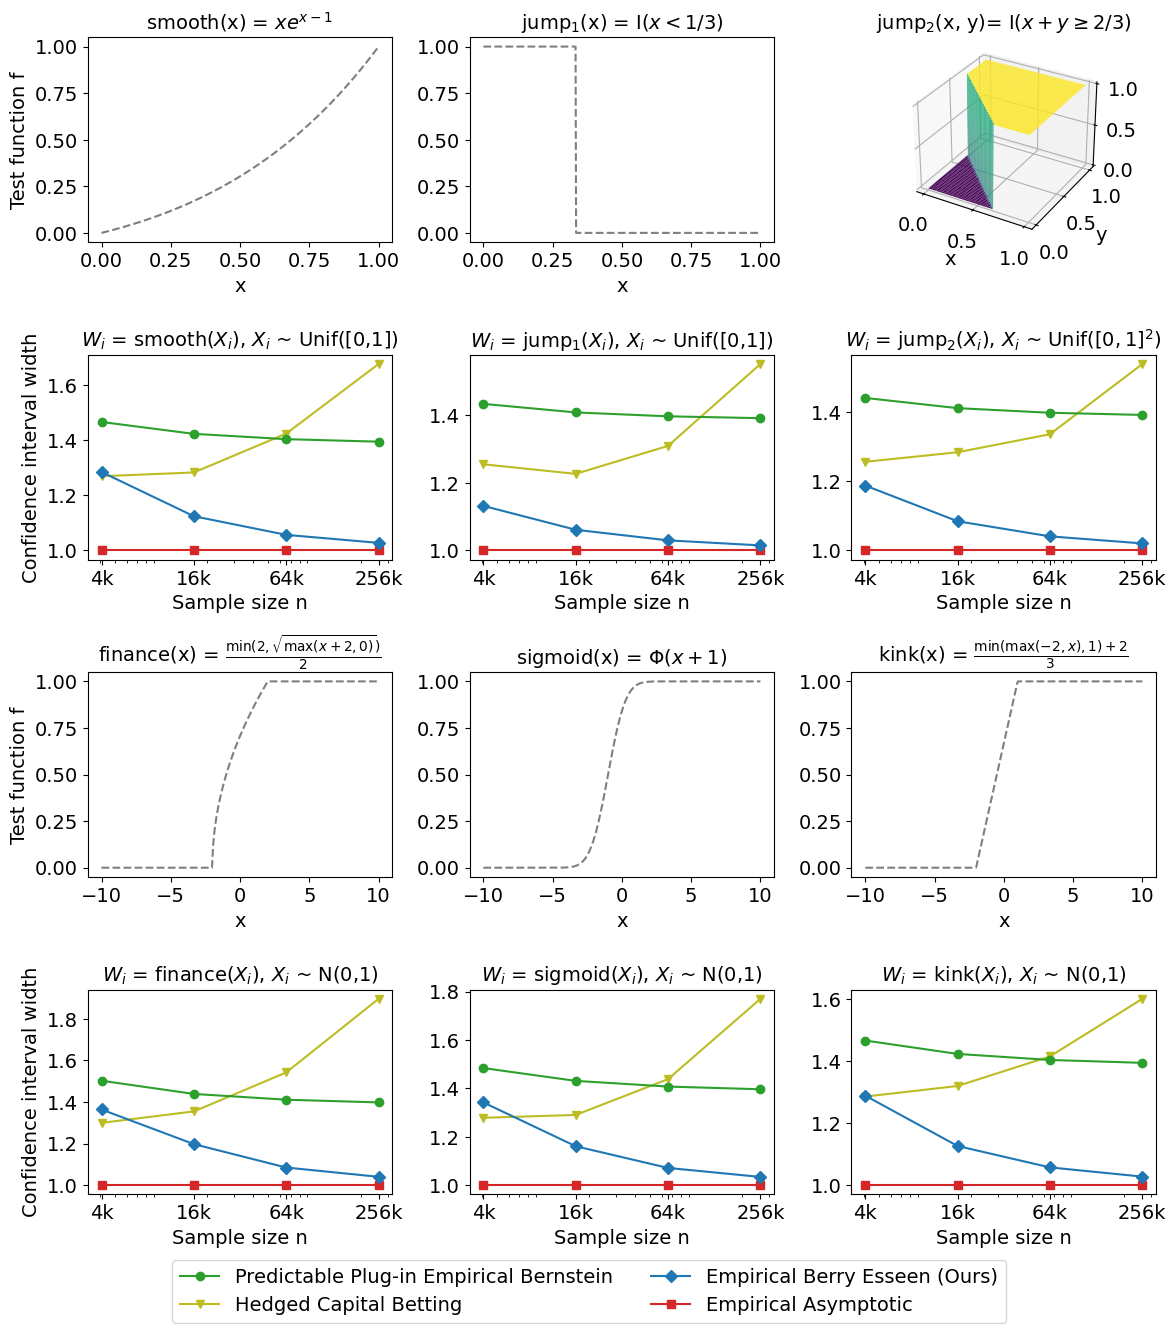

In [9]:
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from helpers import savefig

df["Ratioavg"] = df.loc[:, "Ratio1":f"Ratio{M}"].mean(axis=1)
df["Ratiostd"] = df.loc[:, "Ratio1":f"Ratio{M}"].std(axis=1)
df["Mavg"] = df.loc[:, "M1":f"M{M}"].mean(axis=1)
df["Mstd"] = df.loc[:, "M1":f"M{M}"].std(axis=1)
df["Lavg"] = df.loc[:, "L1":f"L{M}"].mean(axis=1)
df["Lstd"] = df.loc[:, "L1":f"L{M}"].std(axis=1)
df["Uavg"] = df.loc[:, "U1":f"U{M}"].mean(axis=1)
df["Ustd"] = df.loc[:, "U1":f"U{M}"].std(axis=1)
summ = df.loc[(df["n_vary"]==1)&((df["Dimension"]=="") | (df["Dimension"]==1)),
              ["N_vary", "Function", "CI Method", "Mavg", "Mstd", "Lavg", "Lstd", "Uavg", "Ustd", "Ratioavg", "Ratiostd"]]

# Names for functions and methods in the plots
plotnames = {
    'smo': 'sigmoid',
    'jmp': 'jump',
    'knk': 'kink',
    'fin': 'finance',
    'smooth_1d': 'smooth',
    'discontinuous_1d': r'jump$_1$',
    'discontinuous_2d': r'jump$_2$',
    'CLT': 'Empirical Asymptotic',
    'EB': 'Predictable Plug-in Empirical Bernstein',
    'Betting': 'Hedged Capital Betting', # Capital Betting',
    'EBE': 'Empirical Berry Esseen (Ours)'
}
# Colors, markers, and plotting order for methods in the plots
colors = {
    'CLT': 'tab:red',
    'EB': 'tab:green',
    'Betting': 'tab:olive',
    'EBE': 'tab:blue',
}
markers = {
    'CLT': 's',
    'EB': 'o',
    'Betting': 'v', 
    'EBE': 'D'
}
# Higher zorders get plotted on top
zorders = {
    'CLT': 1,
    'EB': 3,
    'Betting': 2, 
    'EBE': 4
}
# Function definitions
defs = {
    'smo': r'$\Phi(x+1)$',
    'jmp': r'I$(x \geq 1)$',
    'knk': r'$\frac{\min(\max(-2,x),1)+2}{3}$',
    'fin': r'$\frac{\min(2, \sqrt{\max(x+2,0)})}{2}$',
    'smooth_1d': r'$xe^{x−1}$',
    'discontinuous_1d': r'I$(x < 1/3)$',
    'discontinuous_2d': r'I$(x + y \geq 2/3)$'
}

# Create subplots with four rows
# The first row plots the Ratioavg vs. N_vary for each CI method for the corresponding functions in gs
# The second row plots each of the functions in gs[1:]
# The third row plots the Ratioavg vs. N_vary for each CI method for the corresponding functions in fs
# The fourth row plots each of the functions in fs
plot_ci_methods = ['EB', 'Betting', 'EBE', 'CLT']
sub_gs = {key: value for key, value in gs.items() if key != 'jmp'}
fontsize = 14
plt.rcParams['font.size'] = str(fontsize)
num_rows = 4
num_cols = max(len(sub_gs), len(fs))
plt.close('all')
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols,
                         #sharey='row',
                         figsize=(num_cols*4,num_rows*4/(5/4)),
                         ###gridspec_kw={'height_ratios': [1, 1.5, 1, 1.5]}
                         )

for jj, func in enumerate(fs.keys()):
    ci_ax = axes[1, jj]
    func_ax = axes[0, jj]
    if jj == 0:
        ci_ax.set_ylabel(r"Confidence interval width")
        func_ax.set_ylabel(r"Test function f")
    # Plot the Ratioavg vs. N_vary for each CI method
    for ci_method in plot_ci_methods:
        data = summ[(summ["Function"] == func) & (summ["CI Method"] == ci_method)]
        ci_ax.plot(data["N_vary"], data["Ratioavg"], label=plotnames[ci_method], 
                   color=colors[ci_method], marker=markers[ci_method], zorder=zorders[ci_method])
        ci_ax.set_xscale("log")
        ci_ax.set_xlabel(f"Sample size n")
        ci_ax.set_xticks([4**g for g in [6, 7, 8, 9]])
        ###ci_ax.set_xticklabels([fr'$4^{g}$' for g in [6, 7, 8, 9]])
        ci_ax.set_xticklabels(["4k", "16k", "64k", "256k"])
    # Plot the fs function
    if func == "discontinuous_2d":
        x = np.linspace(0, 1, 100)
        y = np.linspace(0, 1, 100)
        X, Y = np.meshgrid(x, y)

        ax_to_convert = func_ax
        rows, cols = ax_to_convert.get_subplotspec().get_geometry()[0:2]

        # Remove the old 2D axes
        ax_to_convert.remove()

        # Add a new 3D axes in the same position
        func_ax = fig.add_subplot(rows, cols, jj+1, projection='3d')
        func_ax.plot_surface(X, Y, fs[func](np.concatenate([X[..., np.newaxis], Y[..., np.newaxis]], axis=2)), cmap='viridis')
        func_ax.set_xlabel(r"x")
        func_ax.set_ylabel(r"y")
        func_ax.set_title(fr"{plotnames[func]}(x, y)= {defs[func]}", fontsize=fontsize)
        ci_ax.set_title(fr"$W_i$ = {plotnames[func]}($X_i$), $X_i$ ~ Unif($[0,1]^2$)",fontsize=fontsize)
    else:
        x_values = np.linspace(0, 1, 500)[..., np.newaxis]
        func_ax.plot(x_values, fs[func](x_values), color='tab:gray', linestyle='--')
        func_ax.set_xlabel(r"x")
        func_ax.set_title(fr"{plotnames[func]}(x) = {defs[func]}", fontsize=fontsize)
        ci_ax.set_title(fr"$W_i$ = {plotnames[func]}($X_i$), $X_i$ ~ Unif([0,1])",fontsize=fontsize)

for jj, func in enumerate(reversed(sub_gs.keys())):
    ci_ax = axes[3, jj]
    func_ax = axes[2, jj]
    if jj == 0:
        ci_ax.set_ylabel(r"Confidence interval width")
        func_ax.set_ylabel(r"Test function f")
    # Plot the Ratioavg vs. N_vary for each CI method
    for ci_method in plot_ci_methods:
        data = summ[(summ["Function"] == func) & (summ["CI Method"] == ci_method)]
        ci_ax.plot(data["N_vary"], data["Ratioavg"], label=plotnames[ci_method], 
                   color=colors[ci_method], marker=markers[ci_method], zorder=zorders[ci_method])
        ci_ax.set_xscale("log")
        ci_ax.set_xlabel(f"Sample size n")
        ci_ax.set_xticks([4**g for g in [6, 7, 8, 9]])
        ###ci_ax.set_xticklabels([fr'$4^{g}$' for g in [6, 7, 8, 9]])
        ci_ax.set_xticklabels(["4k", "16k", "64k", "256k"])
        ci_ax.set_title(fr"$W_i$ = {plotnames[func]}($X_i$), $X_i$ ~ N(0,1)",fontsize=fontsize)
    # Plot the gs function
    x_values = np.linspace(-10, 10, 500)
    func_ax.plot(x_values, sub_gs[func](x_values), color='tab:gray', linestyle='--')
    func_ax.set_xlabel(r"x")
    func_ax.set_title(fr"{plotnames[func]}(x) = {defs[func]}",fontsize=fontsize)


# Add a single figure-level legend
# Use a list of handles (e.g., from a single plot) and labels
handles, labels = ci_ax.get_legend_handles_labels()

# Reorder handles and labels 
ordered_labels = [plotnames[label] for label in plot_ci_methods]
ordered_handles = [h for label in ordered_labels for h, l in zip(handles, labels) if l == label]
fig.legend(ordered_handles, ordered_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
print(ordered_labels)

fig.tight_layout()
#plt.subplots_adjust(wspace=0)
#plt.subplots_adjust(hspace=0.4)
plt.show()

savefig(fig,f"relative_ci_width.pdf", fig_dir="figs")
plt.close('all')
